Codigo de ejecucion del codigo de redes opticas

C:\Users\david\AppData\Local\Temp\ipykernel_10968\62638049.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Using cpu device


C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


------------------------------
| time/              |       |
|    fps             | 4969  |
|    iterations      | 1     |
|    time_elapsed    | 4     |
|    total_timesteps | 20480 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1862         |
|    iterations           | 2            |
|    time_elapsed         | 21           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0053030425 |
|    clip_fraction        | 0.0448       |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.2        |
|    explained_variance   | 0.000144     |
|    learning_rate        | 0.00025      |
|    loss                 | 3.87e+05     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00572     |
|    std                  | 1            |
|    value_loss           | 5.91e+05     |
---------

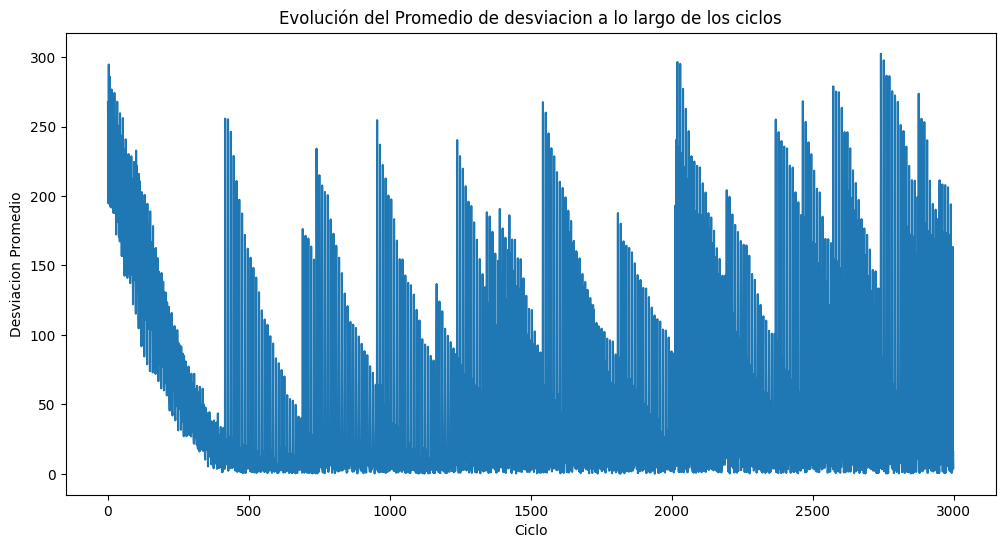

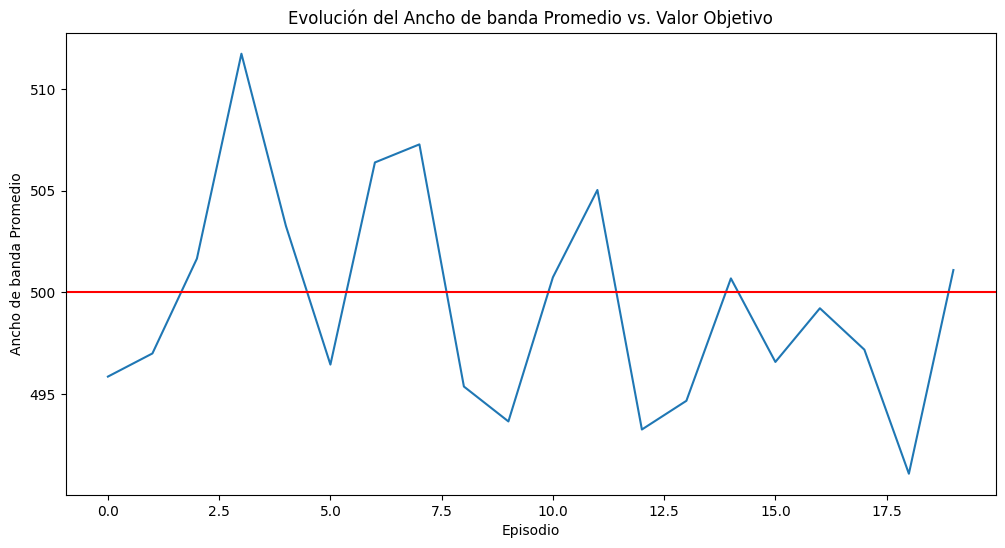

,Ancho de banda primer ciclo,Ancho de banda ultimo ciclo,Desviacion del bgarantizado primer ciclo,Desviacion del bgarantizado ultimo ciclo
0,29.079042,495.405151,470.920958,4.594849
1,230.999542,503.941620,269.000458,3.941620
2,176.547424,495.314087,323.452576,4.685913
3,773.647705,496.014587,273.647705,3.985413
4,82.764877,504.439331,417.235123,4.439331
5,483.216827,504.743530,16.783173,4.743530
6,625.369629,495.819519,125.369629,4.180481
7,226.489716,504.156067,273.510284,4.156067
8,83.815742,497.199097,416.184258,2.800903
9,589.709900,505.018982,89.709900,5.018982


In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.utils import set_random_seed
from custom_env.redes_opticas_env import RedesOpticasEnv  # Asegúrate de que esta ruta sea correcta

def make_env(env_id: str, rank: int, seed: int):
    def _init():
        try:
            env = gym.make(env_id, render_mode=None, seed=seed)  # Cambia a None si no quieres modo visual
            env.reset(seed=seed + rank)
            return env
        except Exception as e:
            print(f"Error al inicializar el entorno: {e}")
            raise e
    set_random_seed(seed)
    return _init

if __name__ == "__main__":
    env_id = 'RedesOpticasEnv-v0'  # Hay que asegurarse de que este ID coincida con el registrado
    num_test = 10  
    seed = np.random.randint(0, 10)
    vec_env = DummyVecEnv([make_env(env_id, i, seed) for i in range(num_test)])
    model = PPO("MultiInputPolicy", vec_env, verbose=1, n_steps=2048, learning_rate=0.00025, gamma=0.99, gae_lambda=0.95)
    model.learn(total_timesteps=200_000)

    # Fase de prueba
    num_test_episodes = 20  # Número de episodios de prueba

    bgarantizado=500

    episode_info = []  # Lista para guardar la información de cada episodio

    band_onu = [[] for _ in range(num_test_episodes)]  # Lista de listas para almacenar band_onus por episodio
    mean_band_onu = []  # Lista para almacenar promedios por episodio

    average_deviation=[]


    for episode in range(num_test_episodes):
        obs = vec_env.reset()  # Resetea el entorno al estado inicial
        done = np.array([False]*num_test)  # Inicializa 'done' para todos los entornos
        deviations = []  # Lista para guardar las desviaciones de cada paso


        while not done.all():
            action, _states = model.predict(obs, deterministic=True)  # Usa el modelo para predecir la acción
            obs, rewards, dones, info = vec_env.step(action)  # Ejecuta la acción en el entorno
            episode_info.append(info)  # Guarda la información del paso
            done |= dones  # Actualiza 'done' para todos los entornos
            for inf in info:
                deviation = inf['average_deviation_from_bgarantizado']
                deviations.append(deviation)

                band_onu[episode].append(inf['band_onus'])

        mean_band_onu.append(np.mean(band_onu[episode]))   

    #print(episode_info)

    print(f"En el ultimo episodio el ancho de banda de las onus del primer ciclo es de: {band_onu[len(band_onu)-1][0]}")
    print(f"En el ultimo episodio el ancho de banda de las onus del ultimo ciclo es de: {band_onu[len(band_onu)-1][len(band_onu[len(band_onu)-1])-1]}")

    print(f"En el primer episodio la desviacion del ancho de banda del primer ciclo es de: {abs(bgarantizado-band_onu[len(band_onu)-1][0])}")
    print(f"En el ultimo episodio la desviacion del ancho de banda del ultimo ciclo es de: {abs(bgarantizado-band_onu[len(band_onu)-1][len(band_onu[len(band_onu)-1])-1])}")

    deviation_avg_per_episode = []

    ultimo_episodio = band_onu[-1]  # Accede directamente al último episodio

    for i, ancho_de_banda in enumerate(ultimo_episodio):
        #print(f"El ancho de banda del ciclo {i+1} es de: {ancho_de_banda}")
        desviacion = np.abs(bgarantizado - ancho_de_banda)
        #print(f"La desviación del ancho de banda del ciclo {i+1} es de: {desviacion}")
        b=np.mean(desviacion)
        #print(f"La media de desviación del ancho de banda del ciclo {i+1} es de: {b}")
        deviation_avg_per_episode.append(b) #Vemos como varia la media de desviacion en cada ciclo de el ultimo episodio el ancho de banda
        #print(f"La desviacion media en el ciclo {i} del ultimo episodio es de: {deviation_avg_per_episode[i]}")


    # Grafica de la evolucion del promedio de la desviacion a lo largo de los ciclos
    plt.figure(figsize=(12, 6))
    plt.plot(deviation_avg_per_episode, label='Desviacion promedio por ciclo')
    plt.xlabel('Ciclo')
    plt.ylabel('Desviacion Promedio')
    plt.title('Evolución del Promedio de desviacion a lo largo de los ciclos')
    plt.savefig('ciclos.png')
    plt.show()

    objective_value=bgarantizado
    
    # Grafica del average del ancho de banda en los diferentes episodios
    plt.figure(figsize=(12, 6))
    plt.plot(mean_band_onu, label='Reward promedio por episodio')
    plt.axhline(y=objective_value, color='r', linestyle='-', label='Valor Objetivo')
    plt.xlabel('Episodio')
    plt.ylabel('Ancho de banda Promedio')
    plt.title('Evolución del Ancho de banda Promedio vs. Valor Objetivo')
    plt.savefig('banda.png')
    plt.show()

    # Crear tabla de valores
    filas=[]
    for i in range(10):

        filas.append({
            'Ancho de banda primer ciclo': band_onu[len(band_onu)-1][0][i],
            'Ancho de banda ultimo ciclo': band_onu[len(band_onu)-1][len(band_onu[len(band_onu)-1])-1][i],
            'Desviacion del bgarantizado primer ciclo': abs(bgarantizado-band_onu[len(band_onu)-1][0][i]),
            'Desviacion del bgarantizado ultimo ciclo': abs(bgarantizado-band_onu[len(band_onu)-1][len(band_onu[len(band_onu)-1])-1][i])

        })

    # Convertir en DataFrame
    df = pd.DataFrame(filas)

    display(df)
    